<h2>Twitter Sentiment Analysis - Analytics Vidhya</h2>

<h3>Problem Statement:</h3>

This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

In [18]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# import train and validation data
train_data = pd.read_csv("E:\\iNeuron\\Projects\\Twitter_Sentiment_Analysis\\Kaggle\\artifacts\\twitter_training.csv", header=None)
val_data = pd.read_csv("E:\\iNeuron\\Projects\\Twitter_Sentiment_Analysis\\Kaggle\\artifacts\\twitter_validation.csv", header=None)

In [20]:
# first five records
train_data.columns = ['id','information','type','text']
train_data.head()

,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [21]:
val_data.columns = ['id','information','type','text']
val_data.head()

,id,information,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


Now, we will first convert the text column into lowercase and convert any row having only numerical data into string. Then, we will use a regex expression to erase the special characters.

In [22]:
train_data['text'] = train_data['text'].str.lower()
train_data['text'] = [str(data) for data in train_data['text']]
train_data['text'] = train_data['text'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
val_data['text'] = val_data['text'].str.lower()
val_data['text'] = [str(data) for data in val_data['text']]
val_data['text'] = val_data['text'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

In [23]:
train_data.head()

,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


To identify the main words that were used per label, a word_cloud was used to see which are the most important words on the train data. For example, on the positive label words such as love and game were mostly used alongside a wide variety of words classified as "good sentiments".

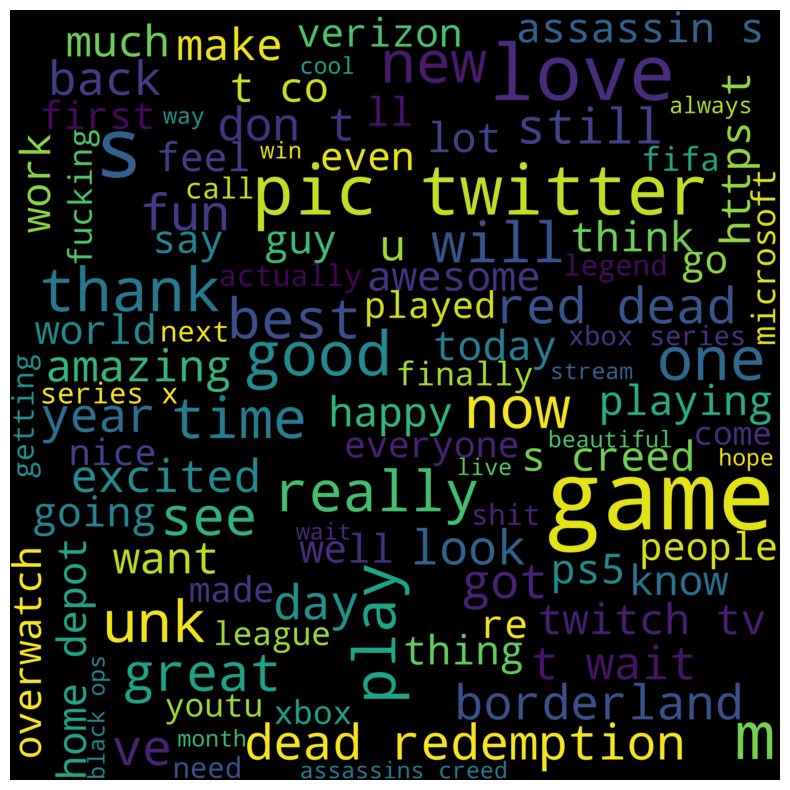

In [24]:
word_cloud_text = ''.join(train_data[train_data["type"]=="Positive"].text)
#Creation of wordcloud
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="black", scale=10, width=800, height=800).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As for the negative tweets, some curse words were the most important while the names of some games and industries were also very used, such as facebook and eamaddennfl.

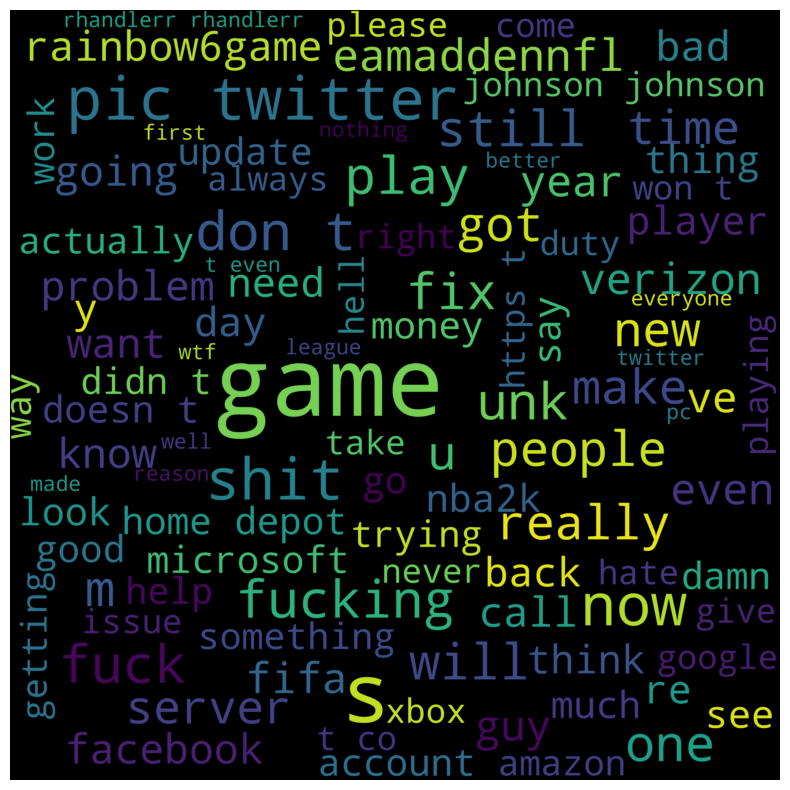

In [25]:
word_cloud_text = ''.join(train_data[train_data["type"]=="Negative"].text)
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The irrelevant tweets show a similar trend as negative ones, something that will impact the overall prediction performance.

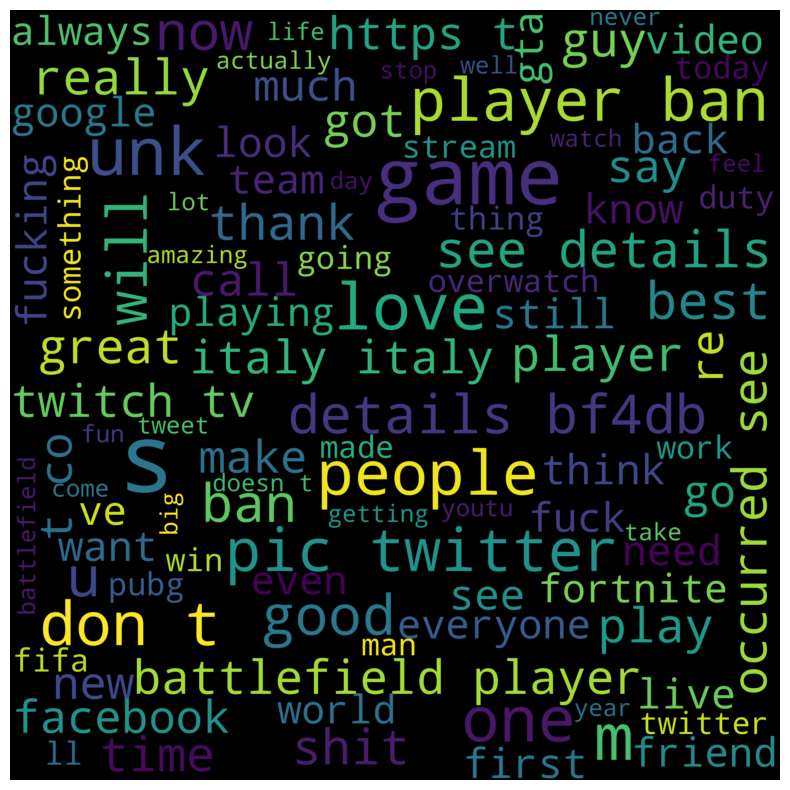

In [26]:
word_cloud_text = ''.join(train_data[train_data["type"]=="Irrelevant"].text)
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Then, on the neutral side, there are almost no curse words and the most important ones are different from the other 3 categories.

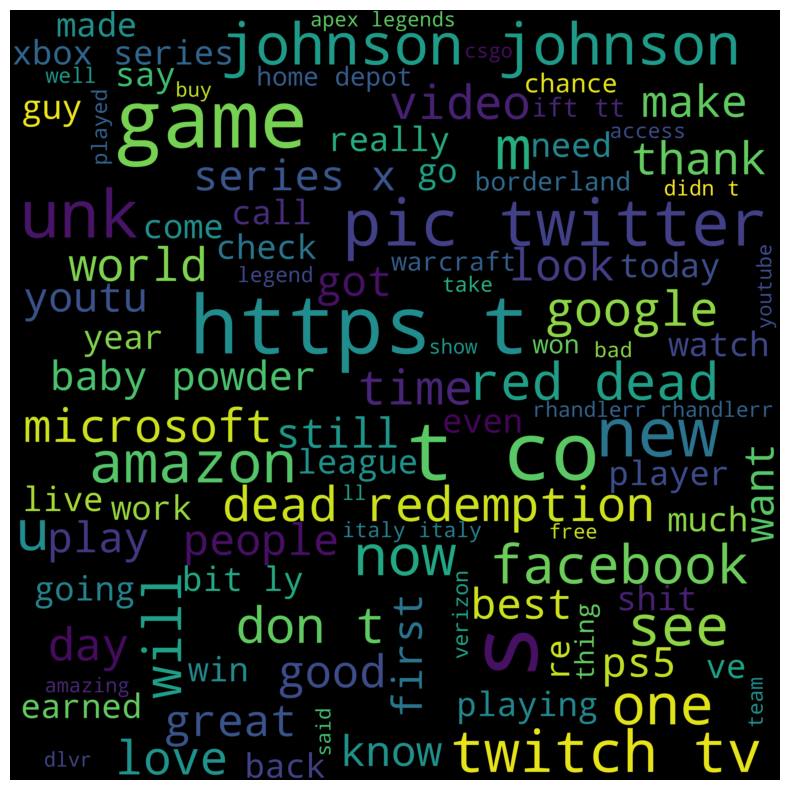

In [27]:
word_cloud_text = ''.join(train_data[train_data["type"]=="Neutral"].text)
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Finally, in this section, the information was grouped by the brand (or in this case the column information) to make a barplot that shows the number of tweets for each one.

In [28]:
#Count information per category
plot1=train_data.groupby(by=["information","type"]).count().reset_index()
plot1.head()

,information,type,id,text
0,Amazon,Irrelevant,192,192
1,Amazon,Negative,576,576
2,Amazon,Neutral,1236,1236
3,Amazon,Positive,312,312
4,ApexLegends,Irrelevant,192,192


As an interesting fact, the number of modified texts coincides with the id. For this reason, as the ID is unique, the following barplot shows that for games such as MaddenNFL and NBA2K the number of negative tweets is the highest while on the other brands the trend is different.

Text(0.5, 1.0, 'Distribution of tweets per Branch and Type')

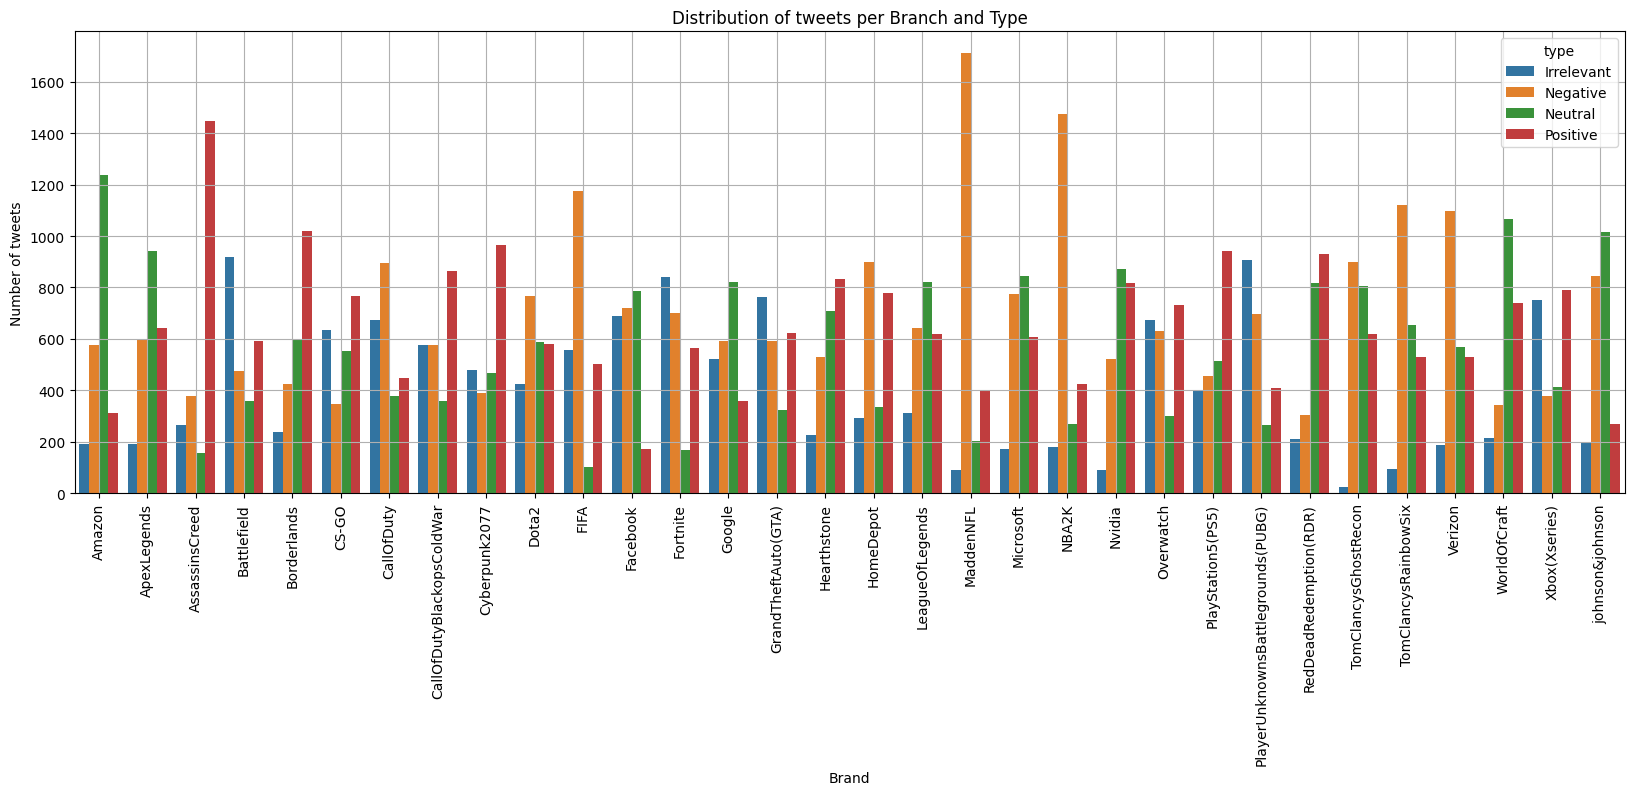

In [29]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=plot1,x="information",y="id",hue="type")
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type")

<h4>Text Analysis:</h4>

In [30]:
# text splitting
tokens_text = [word_tokenize(str(word)) for word in train_data.text]

In [31]:
# Number of unique words
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Number of tokens: ", len(set(tokens_counter)))

Number of tokens:  30436


The tokens_text variable groups all the texts by the different words stored on a List.

In [32]:
tokens_text[1]

['i',
 'am',
 'coming',
 'to',
 'the',
 'borders',
 'and',
 'i',
 'will',
 'kill',
 'you',
 'all']

In [33]:
#Choosing english stopwords
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

<h4>Logistic Regression model:</h4>

In [34]:
#Initial Bag of Words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words, #English Stopwords
    ngram_range=(1, 1) #analysis of one word
)

In [35]:
#Train - Test splitting
reviews_train, reviews_test = train_test_split(train_data, test_size=0.2, random_state=0)

In [37]:
#Creation of encoding related to train dataset
X_train_bow = bow_counts.fit_transform(reviews_train.text)
#Transformation of test dataset with train encoding
X_test_bow = bow_counts.transform(reviews_test.text)

d:\anaconda\envs\Deep_Learning\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [38]:
#Labels for train and test encoding
y_train_bow = reviews_train['type']
y_test_bow = reviews_test['type']

In [39]:
#Total of registers per category
y_test_bow.value_counts() / y_test_bow.shape[0]

Negative      0.299190
Positive      0.282252
Neutral       0.245632
Irrelevant    0.172926
Name: type, dtype: float64

The total number of tweets for each category shows that negative and positive are the most registered while the irrelevant is the lowest.

In [40]:
# Logistic regression
model1 = LogisticRegression(C=1, solver="liblinear",max_iter=200)
model1.fit(X_train_bow, y_train_bow)
# Prediction
test_pred = model1.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred) * 100)

Accuracy:  81.50900448550578


d:\anaconda\envs\Deep_Learning\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [42]:
#Validation data
X_val_bow = bow_counts.transform(val_data.text)
y_val_bow = val_data['type']

In [43]:
Val_res = model1.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow, Val_res) * 100)

Accuracy:  91.7


Finally, another Bag of Words was used. This had an n-gram of 4 while not classifying the stopwords, using all the available information.

The Test dataset got to 90% while on the validation data the accuracy was 98%, showing that this approach was better than the simple n-gram and stopwords model.

In [44]:
#n-gram of 4 words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)
#Data labeling
X_train_bow = bow_counts.fit_transform(reviews_train.text)
X_test_bow = bow_counts.transform(reviews_test.text)
X_val_bow = bow_counts.transform(val_data.text)

In [45]:
model2 = LogisticRegression(C=0.9, solver="liblinear",max_iter=1500)
# Logistic regression
model2.fit(X_train_bow, y_train_bow)
# Prediction
test_pred_2 = model2.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_2) * 100)

Accuracy:  90.79467095132891


In [46]:
y_val_bow = val_data['type']
Val_pred_2 = model2.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow, Val_pred_2) * 100)

Accuracy:  98.6


<h4>XGBoost</h4>

In [47]:
le = LabelEncoder()
y_train_bow_num = le.fit_transform(y_train_bow)
y_test_bow_num=le.transform(y_test_bow)
y_val_bow_num=le.transform(y_val_bow)

In [48]:
XGB=XGBClassifier(objective="multi:softmax",n_estimators=1000,colsample_bytree=0.6, subsample=0.6)
XGB.fit(X_train_bow, y_train_bow_num)
# Prediction
test_pred_2 = XGB.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow_num, test_pred_2) * 100)

In [ ]:
y_val_bow = val_data['type']
Val_pred_2 = XGB.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow_num, Val_pred_2) * 100)

In [ ]:
test_pred_N = XGB.predict(X_train_bow)
print("Accuracy: ", accuracy_score(y_train_bow_num, test_pred_N) * 100)

At a first glance, with the default XGBoost parameters, the model gets a worse accuracy. For this reason, an additional cell was added to see the training performance.

It was found that the accuracy is the lowest of all the modeling, so parameter tuning is required to improve the overall performance.